# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090B Introduction to Data Science

## Lab 4:  Feed Forward Neural Networks - Optimizers 

**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb<br/>
<br/>

### Table of Contents
- Keras Functional API
- Weight Initializers 
- Optimizers
    - SGD
    - Adagrad
    - RMProp
    - Adam
- Image Classifier Example

In [1]:
import copy
import operator
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random as rn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import tensorflow as tf



2024-03-01 13:30:11.985143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# You can adjust the notebook width if you like
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
# Recite the sacred reproducibility incantation 🙏
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(109)
np.random.seed(109)
rn.seed(109)

## Regression with Neural Networks

Let's fit a difficult function where polynomial regression fails. 

The [dielectric function](https://en.wikipedia.org/wiki/Permittivity) of many optical materials depends on the frequency and is given by the Lorentz model as:
$$ \varepsilon(\omega) = 1 - \frac{\omega_0^2}{\omega_0^2-\omega^2 +i\omega\Gamma},$$
where $\omega$ is the frequency, $\omega_0$ is the resonance frequency of the bound electrons, and $\Gamma$ is the electron damping. 

In many situations, we measure the real part of the dielectric function in the lab and then we fit these observations. Let's assume that we perform an experiment and the observations came from a Lorentz model.

In [4]:
df = pd.read_csv('data/lorentz_set.csv').sample(frac=1, random_state=109) # shuffle DataFrame!

# Split train and test
x_train, x_test, y_train, y_test = train_test_split(df.x, df.y, train_size=0.7, random_state=109)

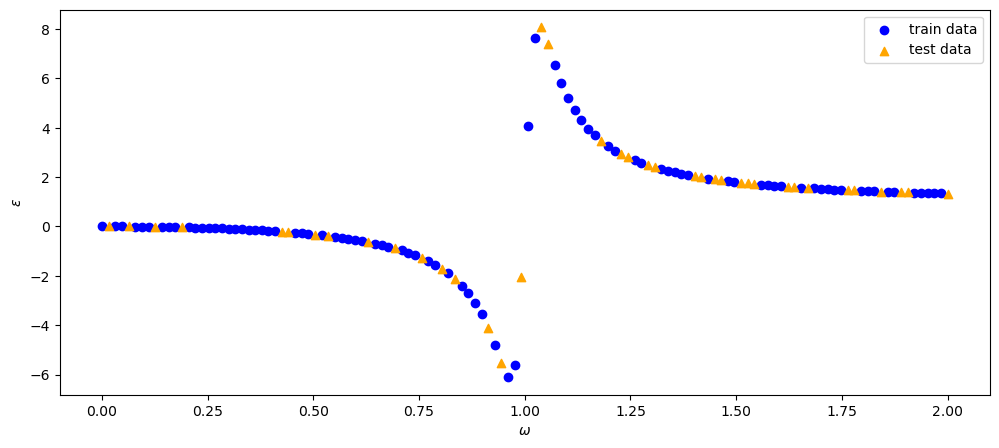

In [5]:
def plot_lorentz(df, test_idx, ax=None):
    if ax is None:
        ax = plt.gca()
    train_mask = np.ones(df.shape[0], dtype=bool)
    train_mask[test_idx] = False
    ax.scatter(df.x[train_mask],df.y[train_mask], c='b', label='train data')
    ax.scatter(df.x[~train_mask],df.y[~train_mask], c='orange', marker='^', label='test data')
    ax.set_xlabel('$\omega$')
    ax.set_ylabel('$\epsilon$')
    ax.legend()

plt.figure(figsize = (12,5));
plot_lorentz(df, x_test.index);

MSE on training set:  1.106083518940591
MSE on testing set:  1.9962599448934577


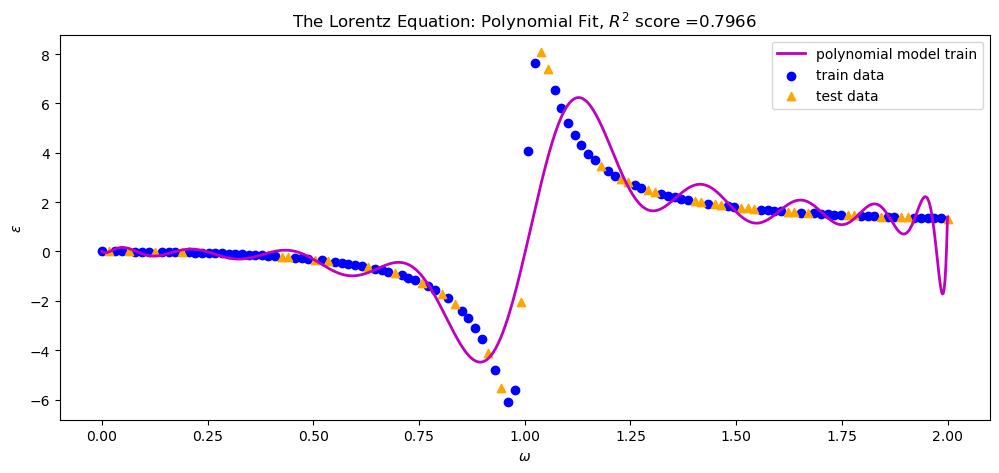

In [6]:
# Fit a 25-degree polynomial function to the data
polynomial_features= PolynomialFeatures(degree=25)
x_poly_train = polynomial_features.fit_transform(x_train.values.reshape(-1,1))
x_poly_test = polynomial_features.fit_transform(x_test.values.reshape(-1,1))

model = LinearRegression()
model.fit(x_poly_train, y_train)
y_poly_train = model.predict(x_poly_train)
y_poly_test = model.predict(x_poly_test)

mse_train_poly = mean_squared_error(y_train, y_poly_train)
mse_test_poly = mean_squared_error(y_test, y_poly_test)
print('MSE on training set: ', mse_train_poly)
print('MSE on testing set: ', mse_test_poly)

x_lin = np.linspace(x_train.min(), x_train.max(), 1000)
x_lin_poly = polynomial_features.fit_transform(x_lin.reshape(-1,1))
y_poly_pred = model.predict(x_lin_poly)

plt.figure(figsize = (12,5))
ax = plt.gca()
ax.plot(x_lin, y_poly_pred, color='m',linewidth=2,label='polynomial model train')
plot_lorentz(df, x_test.index, ax=ax);

ax.set_title("The Lorentz Equation: Polynomial Fit, $R^2$ score ={}".format(round(r2_score(y_train,y_poly_train),4)));

As expected, we get some wile behavior because we need a very high polynomial degree to begin to approximate this function.\

Let's see if we can do better using a **feed forward neural network**. We'll again be using Tensorflow's high-level Keras API. But this time we'll construct our NNs a bit differently...

## Keras Functional API

In [7]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

[Official Keras Guide](https://keras.io/guides/functional_api/)

The Keras functional API is a way to create models that are more flexible than the `tf.keras.Sequential API`. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

You create a node in the graph by instantiating a layer object. A directed connection is created between nodes by passing one node as input to another:
```{python}
inputs = Dense(...)
hidden1 = Dense(...)(inputs)
hidden2 = Dense(...)(hidden1)
output = Dense(...)(hidden2)
```
The model is created with the `tf.keras.Model` constructor, which requires args `inputs` and `outputs`, defining where the graph begins and where it ends.
```{python}
model = tf.keras.Model(inputs=inputs, outputs=outputs)
```

This flexibility allows you to have forking and merging paths in your network. We'll see more complex graph structures like later in the course!

In [8]:
# Read the input data into your neural network
inputs = Input(shape=(1,))

# Pass the data through two densely-connected layers, with hyperbolic tangent activations
# your code here
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)

# Output your predicted y-values, using linear activation
# your code here
# ...
outputs = Dense(1, activation='linear')(x)

# Instantiate your model and name it 'NN1'
# your code here
# ...
NN1 = Model(inputs=inputs, outputs=outputs, name='NN1')

NN1.save_weights('NN1_init.h5')
NN1.summary() # shows the model configuration

Model: "NN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2701 (10.55 KB)
Trainable params: 2701 (10.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Weight Initilizers

[`tf.keras.initializers`](https://keras.io/api/layers/initializers/)

In [9]:
from tensorflow.keras import initializers
from tensorflow.keras.initializers import glorot_normal, glorot_uniform, he_uniform, random_normal

The keyword arguments used for passing initializers to layers depends on the layer. Usually, it is simply `kernel_initializer` and `bias_initializer`.

As we've already seen with Keras objects like optimizers, losses, and metrics, all built-in initializers can also be passed via their string identifier (though this requires that you accept their default parameters if they have any).

The standard initializers you might expect are:
- Normal
- Truncated Normal
- Uniform
- Ones
- Zeros

Some more exotic initializers include:
- Glorot (a.k.a Xavier) normal initializer
    - Draws samples from a truncated normal distribution centered on 0 with `stddev = sqrt(2 / (fan_in + fan_out))` where `fan_in` is the number of input units in the weight tensor and `fan_out` is the number of output units in the weight tensor.
    - [Glorot et al., 2010](http://proceedings.mlr.press/v9/glorot10a.html)
- Glorot (a.k.a. Xavier) uniform initializer
    - Similar idea, except now the limits of the uniform are a function of `fan_in` and `fan_out`.Draws samples from a uniform distribution within `[-limit, limit]`, where `limit = sqrt(6 / (fan_in + fan_out))`.
- HeNormal
    - Just like Glorot normal except it only uses `fan_in`. Draws samples from a truncated normal distribution centered on 0 with `stddev = sqrt(2 / fan_in)`.
    - [He et al., 2015](https://arxiv.org/abs/1502.01852)
    
- HeUniform
    - Draws samples from a uniform distribution within `[-limit, limit]`, where `limit = sqrt(6 / fan_in)`. 
    
As with everything (except possibly early stopping!) there is no free lunch here. The initializer is just another hyperparameter for you to experiment with. And they can indeed have an effect on your model's training, and therefore, its performance as well.

In [10]:
# Helper function for plotting training history
def plot_history(model, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(model.history.history['loss'], label='train')
    ax.plot(model.history.history['val_loss'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE')
    best_loss = np.nanmin(model.history.history['val_loss'])
    ax.axvline(np.nanargmin(model.history.history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    ax.legend()
    ax.set_title(title)

Let's take a look at a few initializers and the resulting weight distributions in the first layer before and after training.

16/16 [==============================] - 0s 2ms/step
CPU times: user 24 s, sys: 4.59 s, total: 28.6 s
Wall time: 20.3 s


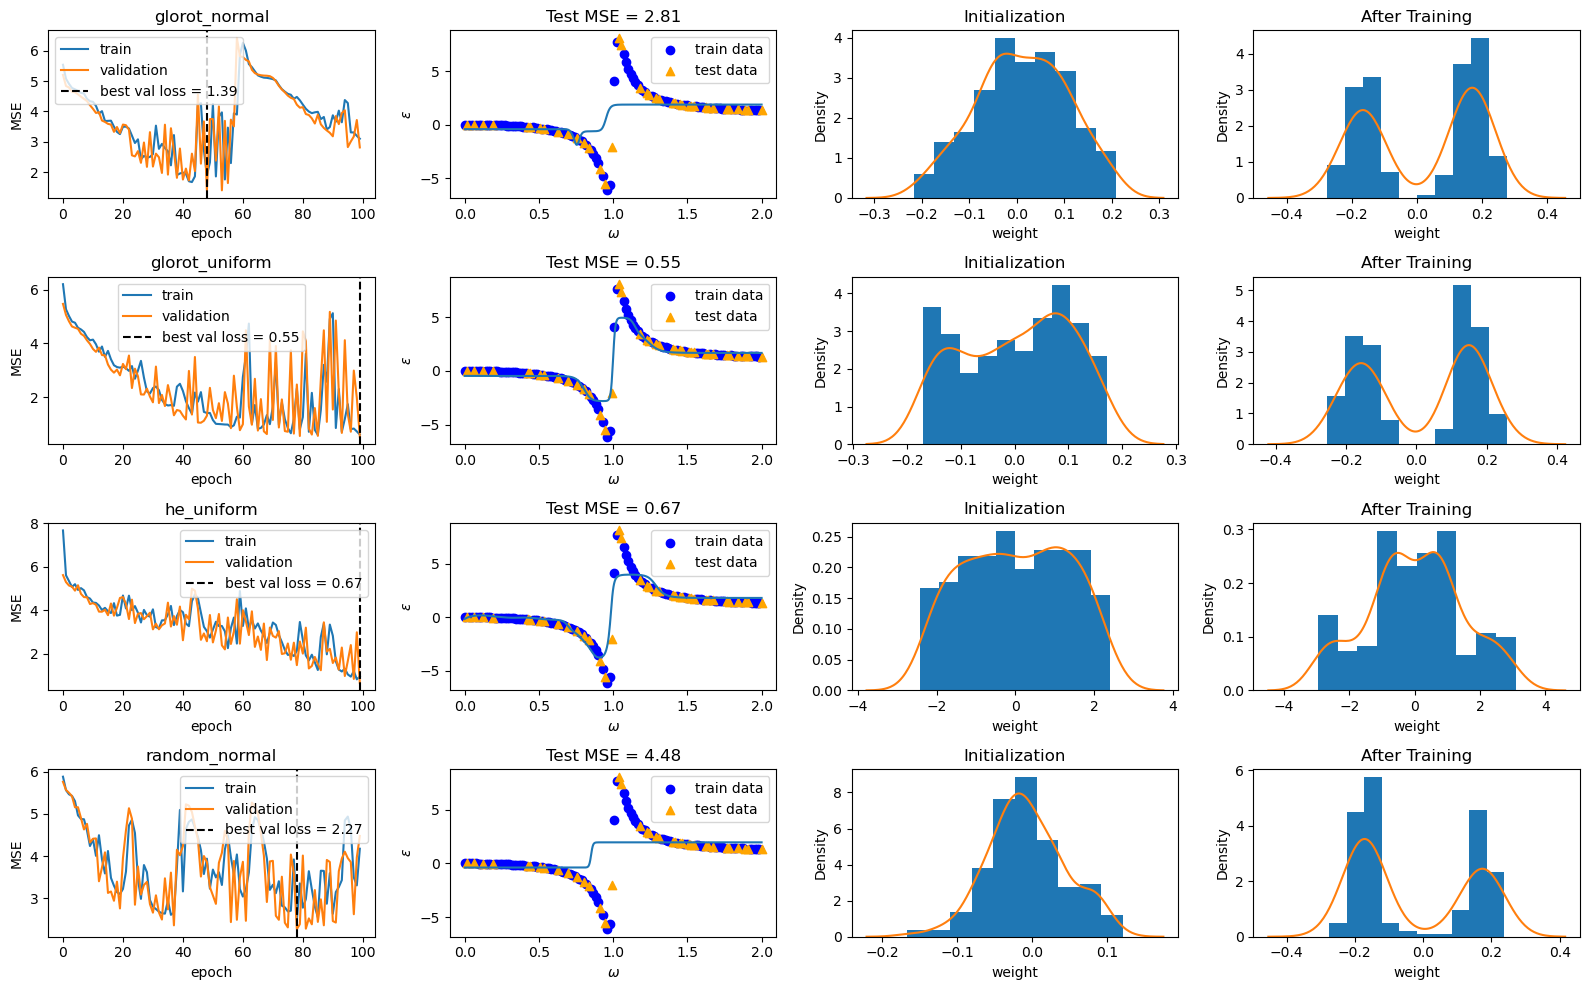

In [11]:
%%time
fig, axs = plt.subplots(4, 4, figsize=(16,10));
kernal_initilizers = ['glorot_normal', 'glorot_uniform', 'he_uniform', 'random_normal']

for i, kernel_initializer in enumerate(kernal_initilizers):
    # Build Model
    inputs = Input(shape=(1,))
    x = Dense(200, activation='tanh', kernel_initializer=kernel_initializer)(inputs)
    x = Dense(50, activation='tanh', kernel_initializer=kernel_initializer)(x)
    x = Dense(5, activation='tanh', kernel_initializer=kernel_initializer)(x)
    outputs = Dense(1, activation='linear', kernel_initializer=kernel_initializer)(x)
    NN1 = Model(inputs=inputs, outputs=outputs, name='NN1')
    # Compile
    NN1.compile(tf.keras.optimizers.Adam(learning_rate=0.01), 'mse')
    # Plot Initial Weights
    first_layer_weights = NN1.get_weights()[0][0]
    axs[i,2].hist(first_layer_weights, density=True)
    sns.kdeplot(first_layer_weights, ax=axs[i,2])
    axs[i,2].set_xlabel('weight')
    axs[i,2].set_title('Initialization')
    
    # Fit
    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=32,
            epochs=100,
            verbose=0)
    # Plot
    # History
    plot_history(NN1, ax=axs[i,0], title=kernel_initializer)
    
    # Predictions
    y_hat = NN1.predict(x_test)
    mse = mean_squared_error(y_test, y_hat)
    x_lin = np.linspace(df.x.min(), df.x.max(), (500)).reshape(-1,1)
    y_hat_lin = NN1.predict(x_lin)
    axs[i,1].plot(x_lin, y_hat_lin);
    plot_lorentz(df, test_idx=x_test.index, ax=axs[i,1])
    axs[i,1].set_title(f'Test MSE = {mse:.2f}')
    
    # Plot Weights after fitting
    first_layer_weights = NN1.get_weights()[0][0]
    axs[i,3].hist(first_layer_weights, density=True)
    sns.kdeplot(first_layer_weights, ax=axs[i,3]);
    axs[i,3].set_xlabel('weight')
    axs[i,3].set_title('After Training')
    
fig.tight_layout();

The distributions of the weights in the first layer after fitting seem to become multi-modal, with peaks on either side of 0. Why might this be the case?

In any event, we can tell from the plots of the model predictions that we still have a lot of room for improvement. All these models seem to be **underfit**. More epochs could help, but let's first explore different options with our **optimizer**.

## Optimizers

Recall that backpropogation uses the chain rule to calculate the gradient of the loss with respect to the weights. But it is gradient descent that actually updates the model weights. How this update is performe is defined by the optimizer.

In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam

### **1. Stochastic Gradient Descent**

[**SGD**](https://keras.io/api/optimizers/sgd/)

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD

Gradient descent optimizer.
```{python}
tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.0,
    nesterov=False,
    name="SGD",
    **kwargs
)
```

For background on nesterov momentum: [Sutskever et al., 2013](http://jmlr.org/proceedings/papers/v28/sutskever13.pdf)

In this optimizer, the gradients are averaged across all $m$ observations in a mini-batch.

$g = \frac{1}{m} \sum_i \nabla_W L(f(x_i; W), y_i)$

- Note If the batch size is 1 (m=1), it would be stochastic gradient descent/SGD as shown on lecture notes.

The comes the update step where the weights are actually adjusted.

$W^* = W - \eta g$

Here, $\eta$ is our learning rate.

Because the gradient is calculated using a random sample (mini-batch), the it is a 'noisy' approximation which can allow us to escape local minima.




Here will start with the default parameters to the **SGD** optimizer.

In [13]:
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1, activation='linear')(x)
NN1 = Model(inputs=inputs, outputs=outputs, name='NN1')
NN1.save_weights('NN1_init.h5')
NN1.summary()

Model: "NN1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_19 (Dense)            (None, 50)                100       
                                                                 
 dense_20 (Dense)            (None, 50)                2550      
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 2701 (10.55 KB)
Trainable params: 2701 (10.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
NN1.load_weights('NN1_init.h5')

# Compile your model using a stochastic gradient descent optimizer with learning rate 0.01 and momentum 0
# Use mean squared error loss
# your code here
# ...
NN1.compile(optimizer=SGD(learning_rate=0.01, momentum=0), loss='mse')

# Fit the network on the training data
NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=50,
        verbose=0);

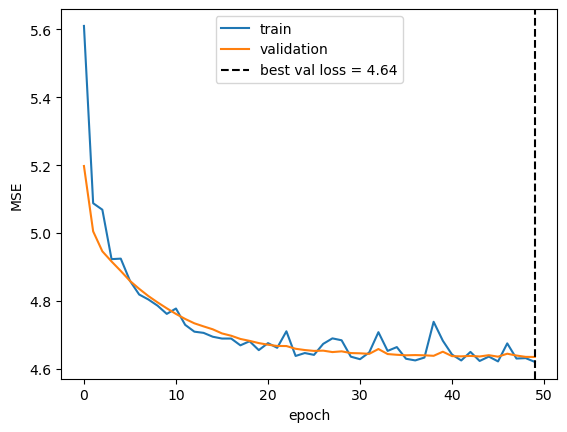

In [15]:
plot_history(NN1)

When performing stochastic gradient descent, batch size is another hyperparameter. It is, after, what makes the optimizer "stochastic!" The smaller the batches, the noiser the approximations of the gradient. Below we try different batch sizes and compare.

Note that rather than re-creating the original network each time, we simply load the weights that were stored upon initialization. Epoch number is enlarged to 200, since training with 50 epochs may not be enough based on the plot above.

**Different Batch Size**

Let's see what happens when using mini-batches of 1, 8, 32, and 128 training data points.

CPU times: user 1min 4s, sys: 4.05 s, total: 1min 8s
Wall time: 57.8 s


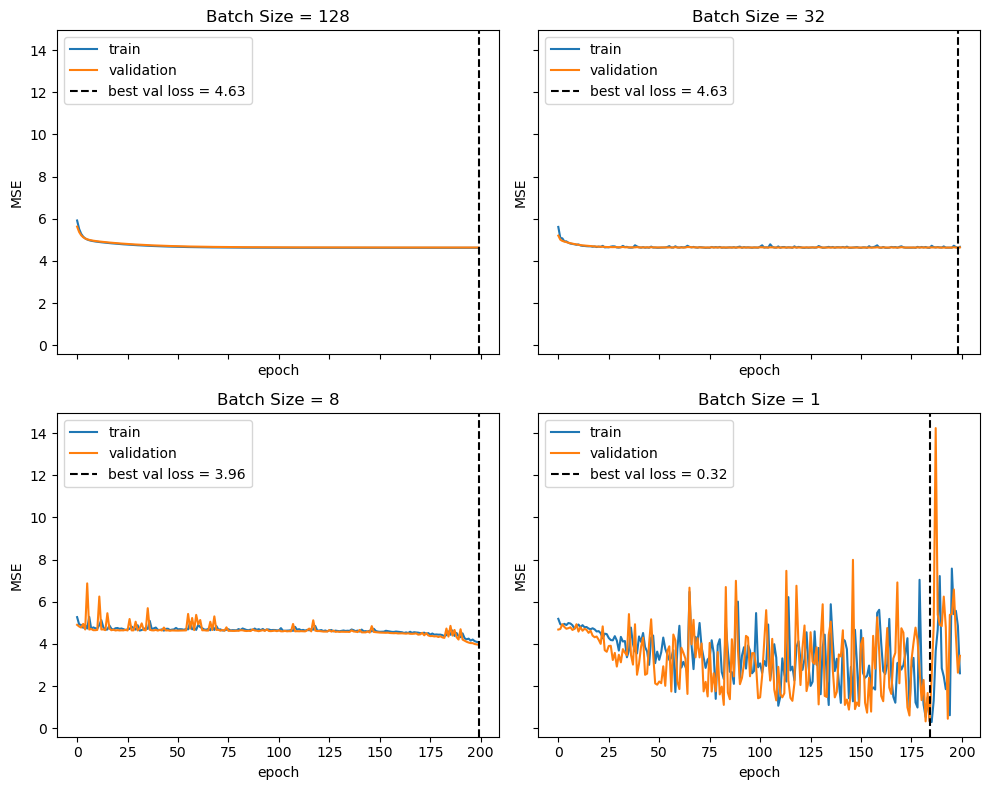

In [16]:
%%time
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True)
axs = axs.flatten()
batch_sizes = [128, 32, 8, 1]
for ax, batch_size in zip(axs, batch_sizes):
    NN1.load_weights('NN1_init.h5')
    NN1.compile(optimizer=SGD(learning_rate=0.01, momentum=0, nesterov=False),
                loss='mse')

    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=batch_size,
            epochs=200,
            verbose=0)
    
    plot_history(NN1, title=f'Batch Size = {batch_size}', ax=ax)
plt.tight_layout()

**Summary**
- batch size = 1: **vanilla SGD**. Just one example at a time to take a single step.
- batch size = m: **mini-batch SGD**. Only the points in the mini batch to calculate the loss function.
- batch size = all the data samples: **batch gradient descent**. 

### 2. SGD with Adaptive Learning Rates
**Learning Rate**

Vanilla SGD has a fixed learning rate. Let's see how adjusting it as a hyperparameter affects the performance of our model.

CPU times: user 30.3 s, sys: 1.71 s, total: 32 s
Wall time: 28.3 s


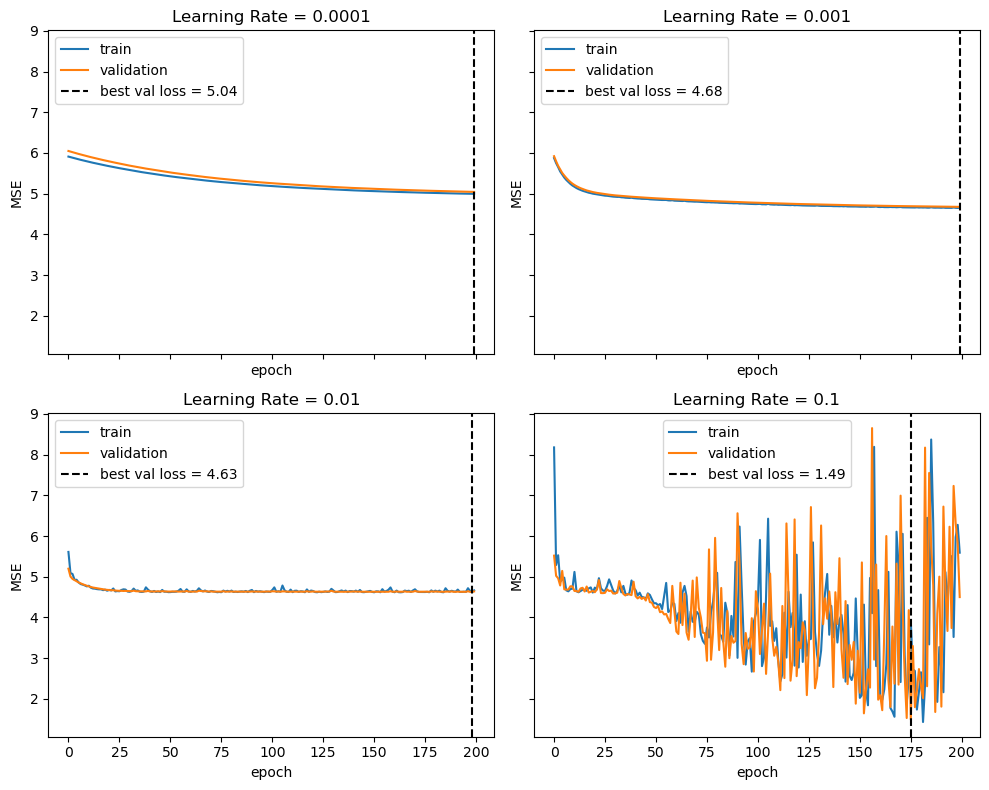

In [17]:
%%time
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True)
axs = axs.flatten()
lrs = [1e-4, 1e-3, 1e-2, 0.1]
for ax, lr in zip(axs, lrs):
    NN1.load_weights('NN1_init.h5')
    NN1.compile(optimizer=SGD(learning_rate=lr, momentum=0),
                loss='mse')

    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=32,
            epochs=200,
            verbose=0)
    
    plot_history(NN1, title=f'Learning Rate = {lr}', ax=ax)
plt.tight_layout()

Clearly some of these learning rates are too low, causing the loss to decrease very slowly as the weight updates are being scaled down considerably. The learning rate of 0.1 reaches a much lower loss, but it starts to oscillate wildly, apparently bouncing in and out of minima because of the high learning rate.

**Learning rate decay / scheduling**

You can use a learning rate schedule to modulate how the learning rate of your optimizer changes over time. You can find more info on schedulers in the [Keras documentation](https://keras.io/api/optimizers/learning_rate_schedules/)

Here we will use [`ExponentialDecay`](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/) to shrink the learning rate over the course of training.

In [27]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

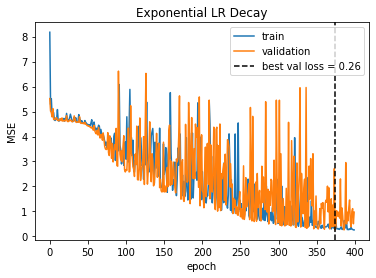

In [28]:
# Try an exponentially-decaying learning rate.
# Use an initial learning rate of 0.1,
# 100 decay steps,
# and a 0.85 decay rate.
# your code here
# lr_schedule = ... 
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100,
    decay_rate=0.85)

NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=SGD(learning_rate=lr_schedule),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=400,
        verbose=0);

plot_history(NN1, title=f'Exponential LR Decay')

[**Adagrad**](https://keras.io/api/optimizers/adagrad/)

Adagrad is an optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training. The more updates a parameter receives, the smaller the updates.

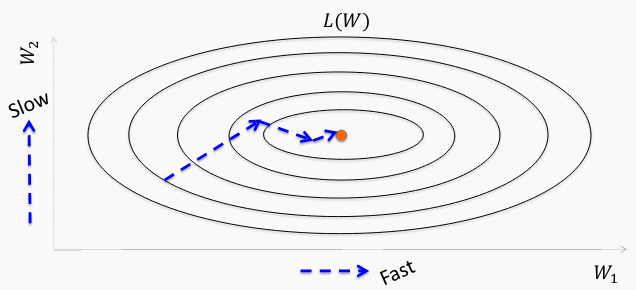

A weight's learning rate is inversely proportional to the root of its accumulated squared component of the gradient seen thus far.

$r^*_i = r_i + g^2_i$

$W^*_i = W_i - \frac{\epsilon}{\delta + \sqrt{r_i}}g_i$
```{python}
tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad",
    **kwargs
)
```
[Duchi et al., 2011](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

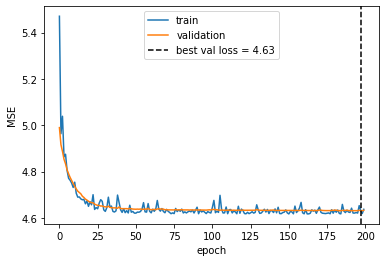

In [29]:
NN1.load_weights('NN1_init.h5')

# Compile the model with an adagrad optimizer with learning rate 0.01
# your code here
# adagrad_optimizer = ... 
adagrad_optimizer = Adagrad(learning_rate=0.01)
NN1.compile(optimizer=adagrad_optimizer, loss='mse')


NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0)

plot_history(NN1)

As you can see, there is a problem with this approach. The accumulated gradients can quickly shrink the learning rates to the point where the network is not longer learning anything.

But we have a fix for this!

---

[**RMSPromp**](https://keras.io/api/optimizers/rmsprop/)

RMSprop maintains a moving (discounted) average of the square of gradients and divides the current gradient by the root of this average (RMS = root mean square).

$r^*_i = \rho r_i + (1-\rho)g^2_i$

$W^*_i = W_i - \frac{\epsilon}{\delta + \sqrt{r_i}}g_i$

```{python}
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
    **kwargs
)
```
[Hinton, 2012](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)

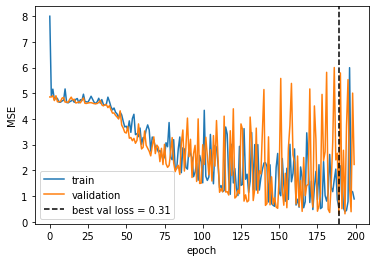

In [30]:
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=RMSprop(learning_rate=0.01, rho=0.9, momentum=0.0),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0)

plot_history(NN1)

This works well, but can we also have it use information about the general trajectory or "trend"?

---

### **3. SGD with Momentum**
If we were to incorporate information about **past updates**, might that help us converge faster?

**Momentum**
Momentum is the first method for using such past information in our updates. This helps us move along with the general trajectory we've taken so far, with oscillations cancelling themselves out.
$$L(W)$$
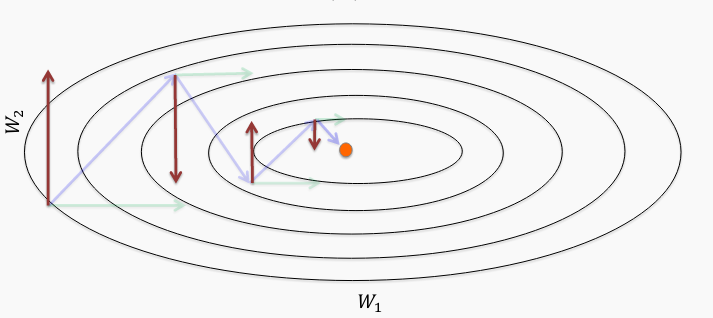

Updates are made using a weighted average of the current gradient, $g$, and the average "trend" seen so far, $v$.\
$v = \alpha v + (1-\alpha)g$

$W^* = W - \eta v$

CPU times: user 23.3 s, sys: 1.68 s, total: 25 s
Wall time: 20.5 s


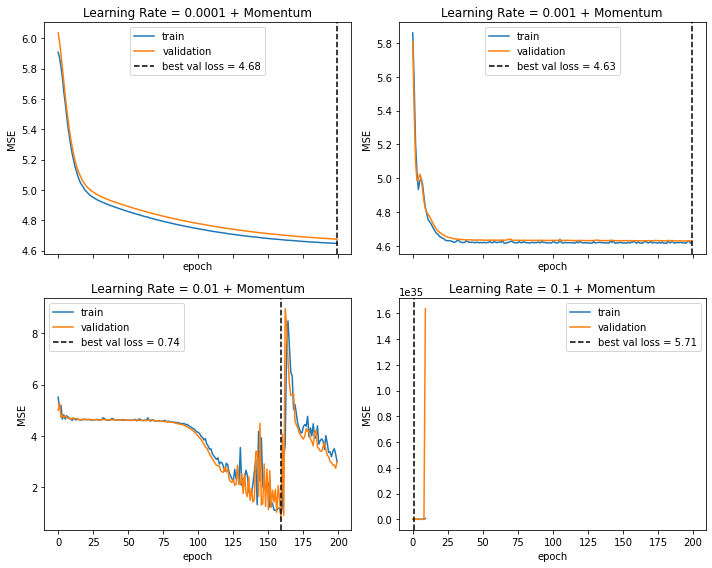

In [31]:
%%time
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True)
axs = axs.flatten()
lrs = [1e-4, 1e-3, 1e-2, 0.1]
for ax, lr in zip(axs, lrs):
    NN1.load_weights('NN1_init.h5')
    NN1.compile(optimizer=SGD(learning_rate=lr, momentum=0.9, nesterov=False),
                loss='mse')

    NN1.fit(x_train, y_train, 
            validation_data=(x_test, y_test),
            batch_size=32,
            epochs=200,
            verbose=0)
    
    plot_history(NN1, title=f'Learning Rate = {lr} + Momentum', ax=ax)
plt.tight_layout()

What happened in the 4th example above? Let's train again with those parameters and look at the detailed output from each epoch.

In [32]:
# Inspect strange behavior in 4th plot above
NN1.load_weights('NN1_init.h5')
NN1.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, nesterov=False),
            loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=15,
        verbose=1)

Epoch 1/15
3/3 [==============================] - 0s 51ms/step - loss: 7.1855 - val_loss: 6.3352
Epoch 2/15
3/3 [==============================] - 0s 14ms/step - loss: 5.5112 - val_loss: 5.7127
Epoch 3/15
3/3 [==============================] - 0s 18ms/step - loss: 10.0647 - val_loss: 13.6631
Epoch 4/15
3/3 [==============================] - 0s 16ms/step - loss: 238.2262 - val_loss: 17568.9512
Epoch 5/15
3/3 [==============================] - 0s 15ms/step - loss: 461027.3750 - val_loss: 72584456.0000
Epoch 6/15
3/3 [==============================] - 0s 16ms/step - loss: 84167950336.0000 - val_loss: 19716041080832.0000
Epoch 7/15
3/3 [==============================] - 0s 20ms/step - loss: 25401484560564224.0000 - val_loss: 5950567374884175872.0000
Epoch 8/15
3/3 [==============================] - 0s 20ms/step - loss: 7666515363319674568704.0000 - val_loss: 1795961312073494739025920.0000
Epoch 9/15
3/3 [==============================] - 0s 24ms/step - loss: 2313858931170459995397423104.00

It looks like the combination of high learning rate and momentum caused a numerical overflow, likely from hitting very 'steep' parts of the loss surface. It is bad news once you get a `nan` in your computations. As you can see, the network weights have all become `nan` as well!

In [33]:
# Ouch! Numerical overflow did in our network
NN1.get_weights()

[array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        na

We take steps to prevent outcomes like this though.

**Gradient Clipping**

The Keras optimizers have clipping aguments 'hidden in the `*kwargs` designation of their docstrings.

Here we use `clipnorm` prevent giant gradients (and thus giant weight updates) from causing problems.

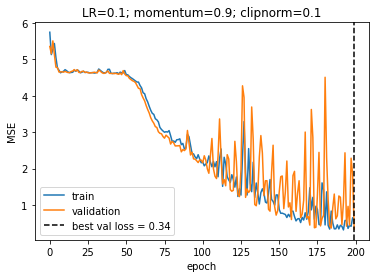

In [34]:
NN1.load_weights('NN1_init.h5')

# Compile the neural network with an SGD optimizer with learning rate 0.1,
# momentum 0.9,  and norm clipping 0.1.
# your code here
# sgd_clipnorm = ... 
sgd_clipnorm = SGD(learning_rate=0.1, momentum=0.9, clipnorm=.1)
NN1.compile(optimizer=sgd_clipnorm, loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0);

plot_history(NN1, title=f'LR=0.1; momentum=0.9; clipnorm=0.1')

---

### **4. SGD with Adaptive Learning Rate + Momentum**

[**Adam**](https://keras.io/api/optimizers/adam/)

Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments (Basically, momentum + RMSProp).
```{python}
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
    **kwargs
)
```
[Kingma et al., 2014](http://arxiv.org/abs/1412.6980)

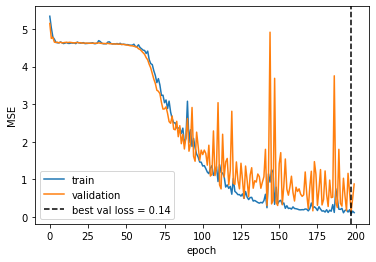

In [35]:
NN1.load_weights('NN1_init.h5')
# Instantiate the Adam optimizer with a learning rate of 0.01
# your code here
# adam_opt = ...
adam_opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
NN1.compile(optimizer=adam_opt, loss='mse')

NN1.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=200,
        verbose=0)

plot_history(NN1)

Very nice. Perhaps the lowest MSE we've seen so far. How does the fit look?

16/16 [==============================] - 0s 1ms/step


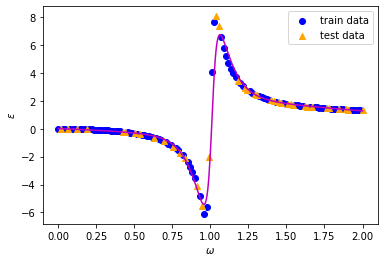

In [36]:
plot_lorentz(df, test_idx=x_test.index)
ax = plt.gca()
x_lin = np.linspace(df.x.min(), df.x.max(), (500)).reshape(-1,1)
y_hat = NN1.predict(x_lin)
ax.plot(x_lin, y_hat, c='m');

Much better than our original polynomial model!

---

**Other Optimizer Implementations Available in Keras:**
- [**Adadelta**](https://keras.io/api/optimizers/adadelta/)
    - Improvement on Adagrad. Adapts learning rates based on a moving window instead of accumulating all past gradients.
- [**Adamax**](https://keras.io/api/optimizers/adamax/)
    - Variant of Adam based on infinity norm (i.e., max).
- [**Nadam**](https://keras.io/api/optimizers/Nadam/)
    - Variant of Adam using nesterov momentum
- [**Ftrl**](https://keras.io/api/optimizers/ftrl/)
    - Implements the "[Follow The Regularized Leader](https://research.google.com/pubs/archive/41159.pdf)" algorithm.

## Overfitting

So far we've been looking at an oversimplified dataset where all the datapoints are right on top of the true generating function. But the real world is noisy!

In [37]:
df2 = pd.read_csv('data/lorentz_noise_set2.csv')
df2 = df2.sample(frac=1, random_state=109) # shuffle DataFrame!
x_train, x_test, y_train, y_test = train_test_split(df2.x, df2.y, train_size=0.7, random_state=109)

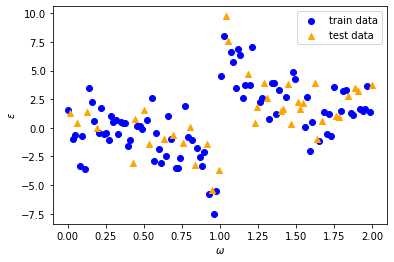

In [38]:
plot_lorentz(df2, x_test.index)

How does our previously best performing model fare on this more realistic dataset?

CPU times: user 55.1 s, sys: 2.34 s, total: 57.4 s
Wall time: 48.6 s


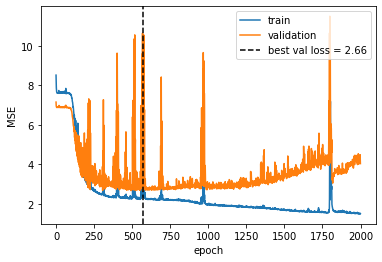

In [39]:
%%time
inputs = Input(shape=(1,))
x = Dense(50, activation='tanh')(inputs)
x = Dense(50, activation='tanh')(x)
outputs = Dense(1, activation='linear')(x)
NN2 = Model(inputs=inputs, outputs=outputs)
NN2.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
            loss='mse')

NN2.fit(x_train, y_train, 
        validation_data=(x_test, y_test),
        batch_size=32,
        epochs=2000,
        verbose=0)

plot_history(NN2);

There are clear signs of overfitting as the validation error starts to diverge from the train error. Any "improvement" seen with respect to the training data after a certain point no longer generalizes. And after a while, we actually start to see the validation loss increasing.

16/16 [==============================] - 0s 1ms/step


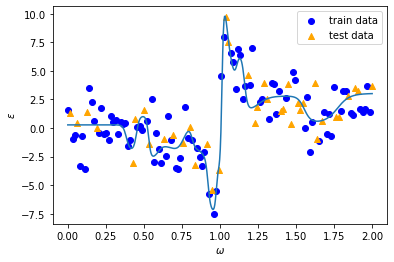

In [40]:
# Plot the overfit predictions
plot_lorentz(df2, test_idx=x_test.index)
ax = plt.gca()
x_lin = np.linspace(df2.x.min(), df2.x.max(), (500)).reshape(-1,1)
y_hat = NN2.predict(x_lin)
ax.plot(x_lin, y_hat);

And here we can see the model predictions jump around as it tries to fit the sparse and noisy points in the training data.\
Luckily we have several tools at our disposal for addressing overfitting in neural networks... to be continued!

## Image Classification with a Feedforward Neural Networks

In this section of the lab we will be working with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).
<img src="https://4.bp.blogspot.com/-OQZGt_5WqDo/Wa_Dfa4U15I/AAAAAAAAAUI/veRmAmUUKFA19dVw6XCOV2YLO6n-y_omwCLcBGAs/s400/out.jpg" width="400px" />

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

We will be using a very small fraction of the dataset. 

In [3]:
# Load entire Fashion-MNIST dataset from Tensorflow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

These are the 10 class labels and the integer they map to in `y_train` and `y_test`.

In [4]:
# Fashion-MNIST class labels
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
label2idx = {label: idx for idx, label in enumerate(labels)}
label2idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Here's some examples from the dataset.

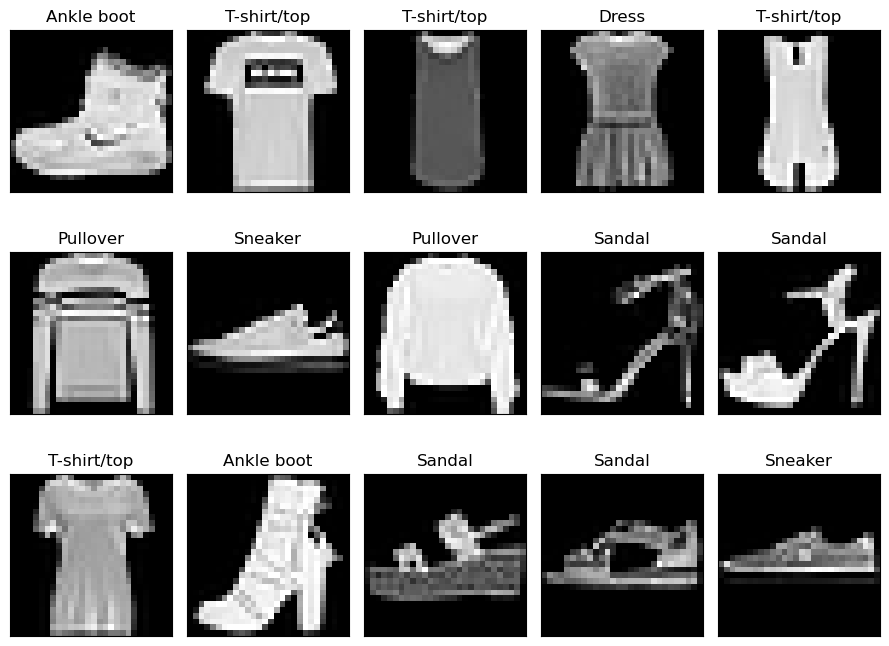

In [5]:
# Fashion-MNIST examples
fig, axs = plt.subplots(3,5, figsize=(9,7))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_train[i], cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(labels[y_train[i]])
plt.tight_layout()

In [6]:
# Dataset size
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

Because we'd like a model we can train multiple times as we experiment during the lab, we will discard most of the training data. We'll do stratified splits to avoid biasing our sample. The classes are equally represented in the original dataset.

In [7]:
# Throw away most of the training data to make things more difficult
# We'll also toss most of the test data (writing it all to disk is slow on JupyterHub!)
_, x_test, _, y_test = train_test_split(x_test, y_test, test_size=0.10, stratify=y_test)
x_train, _, y_train, _ = train_test_split(x_train, y_train, train_size=0.02, stratify=y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

In [8]:
# Sample size
x_train.shape, x_val.shape, x_test.shape

((960, 28, 28), (240, 28, 28), (1000, 28, 28))

In [37]:
y_train[:15]

array([4, 0, 8, 9, 5, 0, 2, 7, 0, 4, 0, 2, 7, 7, 4], dtype=uint8)

In [38]:
from keras.utils import to_categorical

In [39]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

The `PIL` module (Python Image Library) is useful for taking the numpy arrays that currently represent the images and writing them to disk as jpeg files. 

In [40]:
from PIL import Image

<div class='exercise'><b>Construct a Classifier NN</b></div></br>

Let's built our first attempt at a clothing classifier and try to overfit.

Note that Keras has a `Flatten` layer! We can use this to automatically turm input images into 1D arrays.\
(We'll see how to handle 2D input in future lectures and labs) 

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Activation, Input, BatchNormalization, Dense, Dropout, Flatten, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD

In [47]:
# Overfit Fashion-MNIST Classifier
input_dim = x_train.shape[1:]
n_classes = y_train.shape[1]
inputs = Input(shape=input_dim)

# Flatten the inputs here to turn them into 1D arrays.
# your code here
# flat = ... 
flat = Flatten()(inputs)

x = Dense(256, activation=None, kernel_initializer='he_uniform')(flat)
x = Activation('relu')(x)
x = Dense(128, activation=None, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(64, activation=None, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(32, activation=None, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dense(n_classes, activation=None, kernel_initializer='he_uniform')(x)
outputs = Activation('softmax')(x)
NN = Model(inputs, outputs)
NN.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
NN.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               200960    
                                                                 
 activation_25 (Activation)  (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 activation_26 (Activation)  (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 64)                8256

<div class='exercise'><b>Keras Callbacks</b></div></br>

We'll use **early stopping** with short patience so we can call it quits early when it looks like we are overfitting so we can save time. More on this and other regularization techniques on Monday!

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [es]

<div class='exercise'><b>Fit Model with Generator</b></div></br>

Let’s fit the model to the data using the generator. You can use `fit` as before but this time you will pass it generators rather than dataframes or numpy arrays.  

Because the data is being generated endlessly, the Keras model needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn steps_per_epoch batches from the generator—that is, after having run for steps_per_epoch gradient descent steps - the fitting process will go to the next epoch. 

When using `fit`, you can pass a validation_data argument, much as with the fit method. It’s important to note that this argument is allowed to be a data generator, but it could also be a tuple of Numpy arrays. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation

In [49]:
%%time
history = NN.fit(
        x_train,
        y_train,
        epochs=30,
        validation_data=(x_train, y_train),
        callbacks=callbacks,
        # workers=-1,
        # use_multiprocessing=True,
        verbose=1)

Epoch 1/30
30/30 [==============================] - 1s 15ms/step - loss: 42.1202 - accuracy: 0.3823 - val_loss: 9.4720 - val_accuracy: 0.5844
Epoch 2/30
30/30 [==============================] - 0s 9ms/step - loss: 6.3385 - accuracy: 0.5833 - val_loss: 4.4742 - val_accuracy: 0.5885
Epoch 3/30
30/30 [==============================] - 0s 9ms/step - loss: 3.3776 - accuracy: 0.6750 - val_loss: 2.4419 - val_accuracy: 0.6844
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 2.3524 - accuracy: 0.6781 - val_loss: 2.0291 - val_accuracy: 0.6792
Epoch 5/30
30/30 [==============================] - 0s 8ms/step - loss: 1.8531 - accuracy: 0.6646 - val_loss: 1.6947 - val_accuracy: 0.6292
Epoch 6/30
30/30 [==============================] - 0s 8ms/step - loss: 1.6144 - accuracy: 0.6031 - val_loss: 1.2024 - val_accuracy: 0.5625
Epoch 7/30
30/30 [==============================] - 0s 8ms/step - loss: 1.0414 - accuracy: 0.7177 - val_loss: 0.7898 - val_accuracy: 0.7656
Epoch 8/30
30/30 [

<div class='exercise'><b>Evaluate the Model</b></div></br>

In [52]:
NN.evaluate(x_train, y_train)

30/30 [==============================] - 0s 3ms/step - loss: 0.3625 - accuracy: 0.8521


[0.3624926805496216, 0.8520833253860474]

In [53]:
NN.evaluate(x_val, y_val)

8/8 [==============================] - 0s 3ms/step - loss: 2.1989 - accuracy: 0.6458


[2.1988515853881836, 0.6458333134651184]

In [54]:
NN.evaluate(x_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 1.7052 - accuracy: 0.6920


[1.7052167654037476, 0.6919999718666077]

Let’s plot the loss and accuracy of the model over the training and validation data during training:

<div class='exercise'><b>Plot the Training History</b></div></br>

Final Val Acc: 0.85


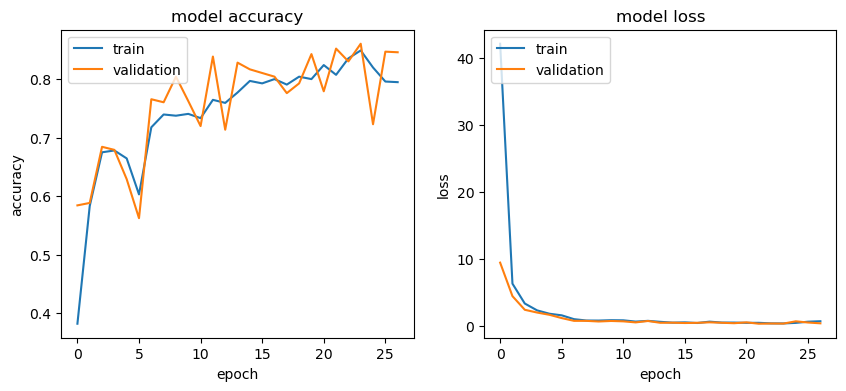

In [55]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
print(f"Final Val Acc: {history.history['val_accuracy'][-1]:.2f}")
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left');

In the next lab we'll look at the idea of data generators which will allow us to create infinite variations on our training data in an attempt to improve generalization!